# Backpropogation Algorithm for Neural Networks

ReLU MSE: 0.000408666485428


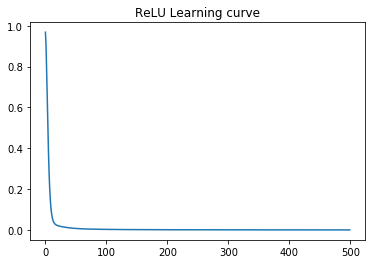

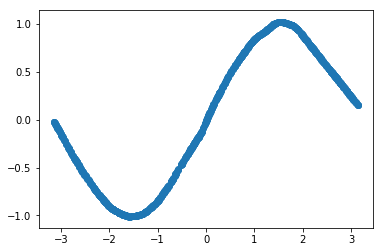

tanh MSE: 0.00126499054514


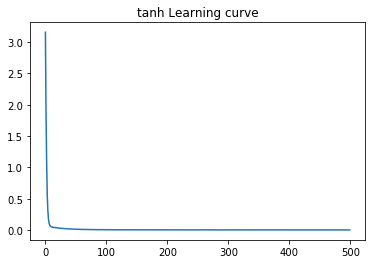

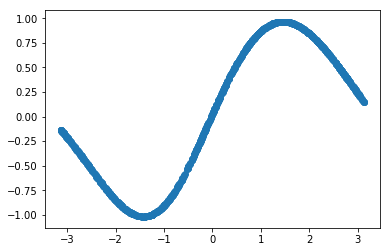

linear MSE: 0.0967346963549


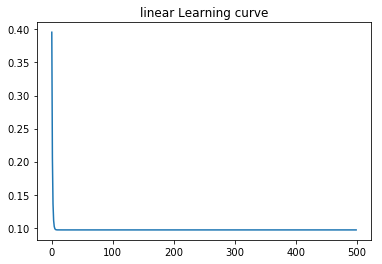

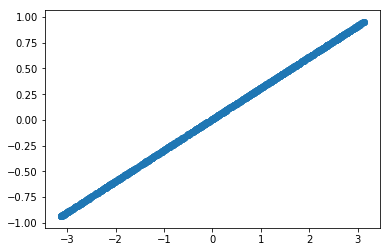

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Gradient descent optimization
# The learning rate is specified by eta
class GDOptimizer(object):
    def __init__(self, eta):
        self.eta = eta

    def initialize(self, layers):
        pass

    # This function performs one gradient descent step
    # layers is a list of dense layers in the network
    # g is a list of gradients going into each layer before the nonlinear activation
    # a is a list of of the activations of each node in the previous layer going 
    def update(self, layers, g, a):
        m = a[0].shape[1]
        for layer, curGrad, curA in zip(layers, g, a):
            # update the weights with the current gradient
            layer.updateWeights(curGrad.dot(curA.T)/1000*self.eta)
            # update the bias for the layer
            biasGrad = curGrad.mean(1).reshape(-1,1)
            biasGrad=biasGrad*self.eta
            layer.updateBias(biasGrad)

# Cost function used to compute prediction errors
class QuadraticCost(object):

    # Compute the squared error between the prediction yp and the observation y
    # This method should compute the cost per element such that the output is the
    # same shape as y and yp
    @staticmethod
    def fx(y,yp):
        cost=0.5*(y-yp)**2
        return cost

    # Derivative of the cost function with respect to yp
    @staticmethod
    def dx(y,yp):
        dcost=yp-y
        return dcost

# Sigmoid function fully implemented as an example
class SigmoidActivation(object):
    @staticmethod
    def fx(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dx(z):
        return SigmoidActivation.fx(z) * (1 - SigmoidActivation.fx(z))
        
# Hyperbolic tangent function
class TanhActivation(object):

    # Compute tanh for each element in the input z
    @staticmethod
    def fx(z):
        return np.tanh(z)

    # Compute the derivative of the tanh function with respect to z
    @staticmethod
    def dx(z):
        dtanh=1-TanhActivation.fx(z)**2
        return dtanh

# Rectified linear unit
class ReLUActivation(object):
    @staticmethod
    def fx(z):
        relu=np.maximum(z,0,z)
        return relu

    @staticmethod
    def dx(z):
        # want to return 1 where z is not 0
        drelu=np.where(z>0,1,0)
        return drelu

# Linear activation
class LinearActivation(object):
    @staticmethod
    def fx(z):
        return z

    @staticmethod
    def dx(z):
        return 1

# This class represents a single hidden or output layer in the neural network
class DenseLayer(object):

    # numNodes: number of hidden units in the layer
    # activation: the activation function to use in this layer
    def __init__(self, numNodes, activation):
        self.numNodes = numNodes
        self.activation = activation

    def getNumNodes(self):
        return self.numNodes

    # Initialize the weight matrix of this layer based on the size of the matrix W
    def initialize(self, fanIn, scale=1.0):
        s = scale * np.sqrt(6.0 / (self.numNodes + fanIn))
        self.W = np.random.normal(0, s,
                                   (self.numNodes,fanIn))
        self.b = np.random.uniform(-1,1,(self.numNodes,1))

    # Apply the activation function of the layer on the input z
    def a(self, z):
        return self.activation.fx(z)

    # Compute the linear part of the layer
    # The input a is an n x k matrix where n is the number of samples
    # and k is the dimension of the previous layer (or the input to the network)
    def z(self, a):
        return self.W.dot(a) + self.b # Note, this is implemented where we assume a is k x n

    # Compute the derivative of the layer's activation function with respect to z
    # where z is the output of the above function.
    # This derivative does not contain the derivative of the matrix multiplication
    # in the layer.  That part is computed below in the model class.
    def dx(self, z):
        return self.activation.dx(z)

    # Update the weights of the layer by adding dW to the weights
    def updateWeights(self, dW):
        self.W = self.W + dW

    # Update the bias of the layer by adding db to the bias
    def updateBias(self, db):
        self.b = self.b + db

# This class handles stacking layers together to form the completed neural network
class Model(object):

    # inputSize: the dimension of the inputs that go into the network
    def __init__(self, inputSize):
        self.layers = []
        self.inputSize = inputSize

    # Add a layer to the end of the network
    def addLayer(self, layer):
        self.layers.append(layer)

    # Get the output size of the layer at the given index
    def getLayerSize(self, index):
        if index >= len(self.layers):
            return self.layers[-1].getNumNodes()
        elif index < 0:
            return self.inputSize
        else:
            return self.layers[index].getNumNodes()

    # Initialize the weights of all of the layers in the network and set the cost
    # function to use for optimization
    def initialize(self, cost, initializeLayers=True):
        self.cost = cost
        if initializeLayers:
            for i in range(0,len(self.layers)):
                if i == len(self.layers) - 1:
                    self.layers[i].initialize(self.getLayerSize(i-1))
                else:
                    self.layers[i].initialize(self.getLayerSize(i-1))

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    # This function returns
    # yp - the output of the network
    # a - a list of inputs for each layer of the newtork where
    #     a[i] is the input to layer i
    # z - a list of values for each layer after evaluating layer.z(a) but
    #     before evaluating the nonlinear function for the layer
    def evaluate(self, x):
        curA = x.T
        a = [curA]
        z = []
        # layers is a list of dense layers in the network
        for layer in self.layers:
            # evaluate layer.z(a)
            curZ = layer.z(curA)
            # append to z
            z.append(curZ)
            # evaluate layer.a(z)
            curA=layer.a(curZ) #get rid of this?
            # the output of a layer is the input to the next layer
            # append to a
            a.append(curA)
        yp = a[-1]
        return yp, a, z

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    def predict(self, a):
        a,_,_ = self.evaluate(a)
        return a.T

    # Train the network given the inputs x and the corresponding observations y
    # The network should be trained for numEpochs iterations using the supplied
    # optimizer
    def train(self, x, y, numEpochs, optimizer):

        # Initialize some stuff
        n = x.shape[0]
        x = x.copy()
        y = y.copy()
        hist = []
        optimizer.initialize(self.layers)
        
        # Run for the specified number of epochs
        for epoch in range(0,numEpochs):

            # Feed forward
            # Save the output of each layer in the list a
            # After the network has been evaluated, a should contain the
            # input x and the output of each layer except for the last layer
            yp, a, z = self.evaluate(x)

            # Compute the error
            C = self.cost.fx(yp,y.T)
            d = self.cost.dx(yp,y.T)
            grad = []
            
            # initialize the multiplicated by d
            f=d
            
            # Backpropogate the error
            idx = len(self.layers)
            for layer, curZ in zip(reversed(self.layers),reversed(z)):
                # compute the gradient of the output wrt error
                curZ = layer.dx(curZ)
                grd = f*curZ
                # append to the list of gradients
                grad.append(grd)
                # update the multiplicated
                f= layer.W.T.dot(grd)

            grad = grad[::-1]

            # Update the errors
            optimizer.update(self.layers, grad, a)

            # Compute the error at the end of the epoch
            yh = self.predict(x)
            C = self.cost.fx(yh,y)
            C = np.mean(C)
            hist.append(C)
        return hist

if __name__ == '__main__':

    # Generate the training set
    np.random.seed(9001)
    x=np.random.uniform(-np.pi,np.pi,(1000,1))
    y=np.sin(x)

    activations = dict(ReLU=ReLUActivation,
                       tanh=TanhActivation,
                       linear=LinearActivation)
    #lr = dict(ReLU=0.1,tanh=0.1,linear=0.01)
    #lr = dict(ReLU=0.001,tanh=0.001,linear=0.0001)
    lr = dict(ReLU=0.02,tanh=0.02,linear=0.001)

    for key in activations:

        # Build the model
        activation = activations[key]
        model = Model(x.shape[1])
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(1,LinearActivation()))
        model.initialize(QuadraticCost())

        # Train the model and display the results
        hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
        yHat = model.predict(x)
        error = np.mean(np.square(yHat - y))/2
        print(key+' MSE: '+str(error))
        plt.plot(hist)
        plt.title(key+' Learning curve')
        plt.show()

        # TODO #################################################################################
        # Plot the approximation of the sin function from all of the models
        # ######################################################################################
        plt.scatter(x,yHat)
        plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Gradient descent optimization
# The learning rate is specified by eta


if __name__ == '__main__':

    # Generate the training set

    np.random.seed(9001)
    x=np.random.uniform(-np.pi,np.pi,(1000,1))
    y=np.sin(x)

    activations = dict(ReLU=ReLUActivation,
                        tanh=TanhActivation,
                        linear=LinearActivation)
    #lr = dict(ReLU=0.1,tanh=0.1,linear=0.01)
    #lr = dict(ReLU=0.001,tanh=0.001,linear=0.0001)
    lr = dict(ReLU=0.02,tanh=0.02,linear=0.001)

    for key in activations:
        #loop over the number of hidden layers
        for num_hid_lay in ([1,2,3]):
            print("hidden layer #" +str(num_hid_lay))
            for num_hid_nodes in ([5,10,20,50]):
                print("hidden nodes #" +str(num_hid_nodes))
                # Build the model
                activation = activations[key]
                model = Model(x.shape[1])
    #             model.addLayer(DenseLayer(100,activation()))
    #             model.addLayer(DenseLayer(100,activation()))
                for hid_lay in range(0,num_hid_lay):
                    model.addLayer(DenseLayer(num_hid_nodes,activation()))
                model.addLayer(DenseLayer(1,LinearActivation()))
                model.initialize(QuadraticCost())

                # Train the model and display the results
                hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
                yHat = model.predict(x)
                error = np.mean(np.square(yHat - y))/2
                print(key+' MSE: '+str(error))
    #             plt.plot(hist)
    #             plt.title(key+' Learning curve')
    #             plt.show()


hidden layer #1
hidden nodes #5
ReLU MSE: 0.0145703688564
hidden nodes #10
ReLU MSE: 0.0275184524808
hidden nodes #20
ReLU MSE: 0.0104970797852
hidden nodes #50
ReLU MSE: 0.00849461283275
hidden layer #2
hidden nodes #5
ReLU MSE: 0.0534164943954
hidden nodes #10
ReLU MSE: 0.00451066038606
hidden nodes #20
ReLU MSE: 0.000972044559191
hidden nodes #50
ReLU MSE: 0.00178109637455
hidden layer #3
hidden nodes #5
ReLU MSE: 0.00712807175693
hidden nodes #10
ReLU MSE: 0.00498662832443
hidden nodes #20
ReLU MSE: 0.000842060632003
hidden nodes #50
ReLU MSE: 0.000582227619032
hidden layer #1
hidden nodes #5
tanh MSE: 0.0426213069288
hidden nodes #10
tanh MSE: 0.00889968240105
hidden nodes #20
tanh MSE: 0.00613650291238
hidden nodes #50
tanh MSE: 0.00339768783866
hidden layer #2
hidden nodes #5
tanh MSE: 0.0103867882741
hidden nodes #10
tanh MSE: 0.00119965944106
hidden nodes #20
tanh MSE: 0.00343872324623
hidden nodes #50
tanh MSE: 0.00111405590307
hidden layer #3
hidden nodes #5
tanh MSE: 0.0344